<h1><font color='Grey'>Plano de Análise</font></h1>
<h4><font color='Grey'>Previsão de preço de passagens</font></h4>

Alcides Gabriel (alcidesgabriel.ds@gmail.com), outubro de 2022

Objetivo: Análisar a interação dos dados com os preços das passagens aéreas.

<h4><font color='Grey'>EDA</font></h4>

1. <font color='green'> Como os dados estão distribuidos?</font>
  
  - Visualização da dispersão dos dados qualitativos e quantitativos.

2. <font color='green'> Como as features se comportam com o preço da passagem? </font>

  - Decomposição e geração das features.
  - Correlação das features com o preço das passagens.
  - Análisar o que é relevante nos dados.



# Importação

- Importação das bibliotecas 
- Importação do dataset

In [5]:
# Stardard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend import FontProperties
import seaborn as sns
import re


# Machine Learning Algorithm 
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor

# Validation and others
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from itertools import combinations

In [8]:
def import_data():
  dt_1 = pd.read_csv('/content/drive/MyDrive/Colab Assuntos Exemplos/Regressão/Preço Passagens/economy.csv')
  dt_2 = pd.read_csv('/content/drive/MyDrive/Colab Assuntos Exemplos/Regressão/Preço Passagens/business.csv')

  return dt_1, dt_2

# Análise Preliminar dos dados

A análise preliminar é feita para ter um diagnóstico do dataset, onde pode-se observar certas características que demonstram a necessidade de certos tratamentos.


## Funções

In [171]:
def DADOS_FUN(df):
  """
  Análise de Composição
  --

  Função Criada com o intuito de avaliar a composição dos dados, ou seja,
  estrutura, tipos, características, etc..

  -----
  df : DataFrame
    Dataset a ser avaliado.
  -----
  """
# ==================== Configurações de Imagem ===========================
  figura = plt.figure(figsize=(20,8))
  tamanho = (1,2)
  plt.suptitle('Composição dos dados', fontsize=25, color='dimgray')
  box = dict(boxstyle='round',alpha=0.5, color='dimgrey')
  plt.subplots_adjust(left=0.1,
                      bottom=0.1,
                      right=0.9,
                      top=0.9,
                      wspace=0.1
                      )

# ==================== Configurações de texto posição 1 ===========================

      ## Informações
  infos = dict()
  infos.update({'linhas':df.shape[0],
                'colunas':df.shape[1],
                'vazios':df.isnull().sum().sum(),
                'duplicados':df.duplicated().sum()})
  try:
    objetos = df.select_dtypes('object').shape[1]
  except:
    objetos = 0

  try:
    numericos = df.select_dtypes(include=np.number).shape[1]
  except:
    numericos = 0 

  infos.update({'objetos':objetos,
                'numéricos':numericos})
  
  
    ## Plot
  pos = (0,0)
  ax = plt.subplot2grid(tamanho, pos)

  l = "\n"
  plt.annotate(f'{l*25} {" "*120}', xy=(0.15,0.2), bbox=box) # Criando o

  cont = 0.75
  for i in infos:

    ax.text(0.54,cont,f'{infos[i]}', fontsize=18)
    ax.text(0.5,cont,f'{i}   :', fontsize=18, horizontalalignment='right', color='white')
    cont -= 0.1

  ax.axis('off')

# ==================== Configuração de Tabela Posição 2 ===========================

      ## Parâmetros
  pos = (0,1)
  ax = plt.subplot2grid(tamanho, pos)

  infos = pd.DataFrame()
  infos['Colunas'] = df.columns
  infos['Tipos'] = df.dtypes.values
  infos['Únicos'] = df.nunique().values
  vazios = list()
  for i in df:
    vazios.append(df[i].isnull().sum()/df.shape[0])
  infos['% de vazios'] = vazios

      ## Tabela
  tabela = ax.table(cellText = infos.values, colLabels=infos.columns,
                    loc='center', cellLoc='center', colLoc='left',rowLoc='right', colWidths=[0.6] * infos.shape[1], bbox=[0,0.17,0.9,0.7], edges='vertical')

            ## Mudando cores na tabela
  for cor in range(infos.shape[0],0,-1):
    for inte in range(4):
      tabela[(cor, inte)].get_text().set_color('grey')

            ## Destaque No Alvo
  try:
    column = infos['Colunas'].tolist().index('price')
    for y_pos in range(infos.shape[1]):
      tabela[(column + 1, y_pos)].get_text().set_color('steelblue')
  except:
    pass

            ## Ajuste de Tamanho
  tabela.auto_set_font_size(False)
  tabela.set_fontsize(16)
  tabela.scale(1,2)         



  ax.axis('off')


## Análise

In [172]:
# Importação dos dados.
dt_1, dt_2 = import_data()

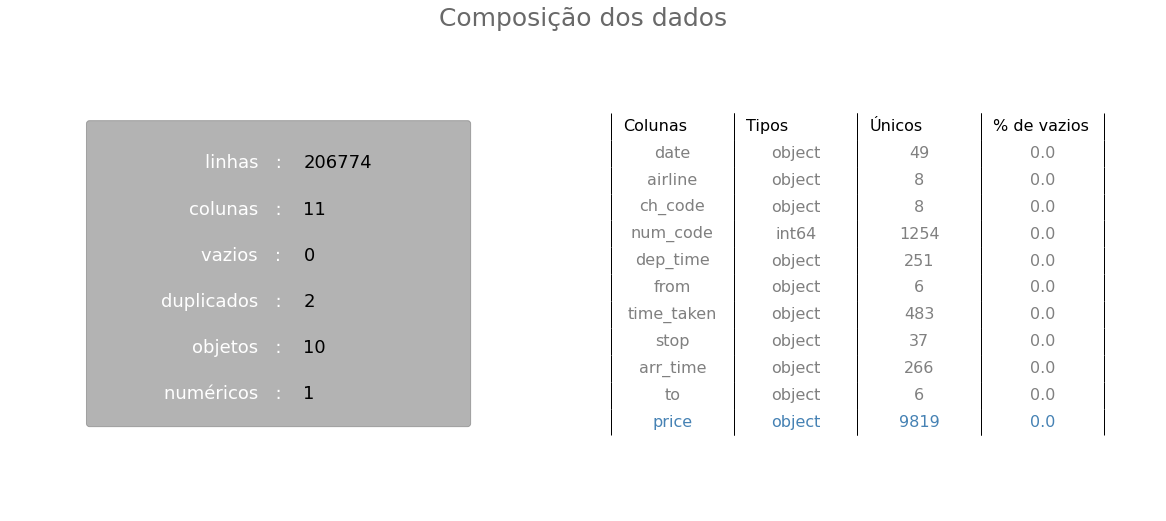

In [173]:
DADOS_FUN(dt_1)

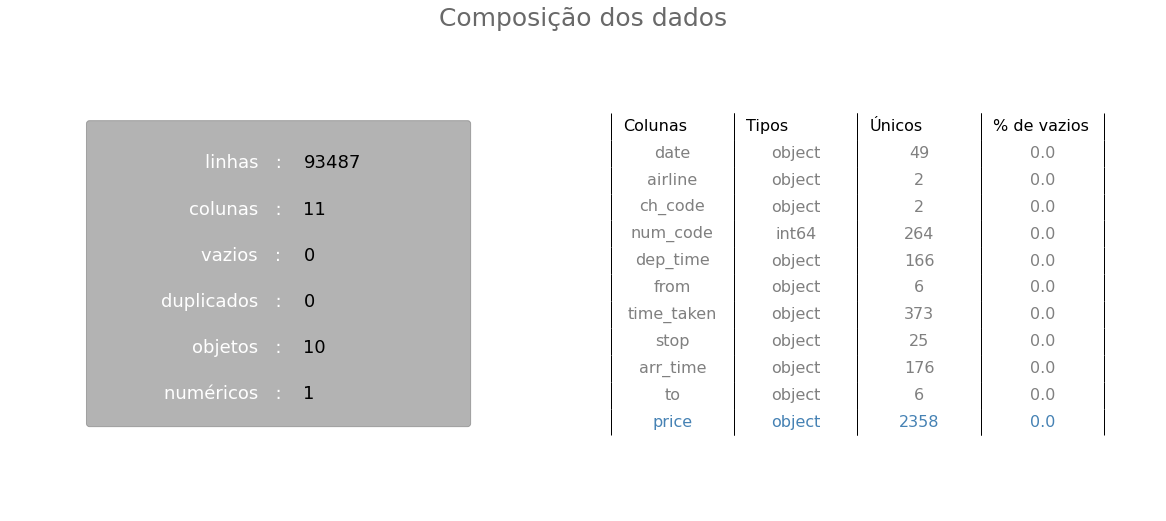

In [174]:
DADOS_FUN(dt_2)

<font color='grey'><h2> Conclusão Análise Primária </h2></font>

- Ambos dos dados são informações das passagens aéreas, sendo que um contém os dados da class económica e outro da classe executiva.

- Os dados da classe económica apresentam 2 dados duplicados (devem ser tratados)

- Os dados devem ser agrupados para predição e tratamento.

- O preço da passagem está no formato objeto e deve ser transformado para o numérico.

# EDA + Feature Engineering


<font color='red'>**EDA - (Exploratory Data Analysis)**</font>   é o ato de explorar o dataset, avaliando tanto os dados qualitativos, quantitativos assim como o target.

<font color='red'>**Feature Engineering**</font>  é toda a alteração feita no dataset, sendo esse processo feito tanto antes quanto depois do EDA, visto há certas informações identificadas anteriormente que necessitam de tratamento (até para a EDA ser mais eficiênte)




## Manipulação dos dados

In [175]:
# Adicionar a classe no dataset
dt_1['class'] = dt_1['airline'].apply(lambda x: 'Economy')
dt_1.head(10)

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953",Economy
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953",Economy
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956",Economy
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955",Economy
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955",Economy
5,11-02-2022,Vistara,UK,945,11:40,Delhi,02h 20m,non-stop,14:00,Mumbai,"5,955",Economy
6,11-02-2022,Vistara,UK,927,09:30,Delhi,02h 05m,non-stop,11:35,Mumbai,"6,060",Economy
7,11-02-2022,Vistara,UK,951,14:20,Delhi,02h 10m,non-stop,16:30,Mumbai,"6,060",Economy
8,11-02-2022,GO FIRST,G8,334,08:00,Delhi,02h 10m,non-stop,10:10,Mumbai,"5,954",Economy
9,11-02-2022,GO FIRST,G8,336,14:20,Delhi,02h 15m,non-stop,16:35,Mumbai,"5,954",Economy


In [176]:
# Adicionar a classe no dataset
dt_2['class'] = dt_2['airline'].apply(lambda x: 'Business')
dt_2.head(10)

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,11-02-2022,Air India,AI,868,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,"25,612",Business
1,11-02-2022,Air India,AI,624,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,"25,612",Business
2,11-02-2022,Air India,AI,531,20:00,Delhi,24h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:45,Mumbai,"42,220",Business
3,11-02-2022,Air India,AI,839,21:25,Delhi,26h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"44,450",Business
4,11-02-2022,Air India,AI,544,17:15,Delhi,06h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"46,690",Business
5,11-02-2022,Vistara,UK,985,19:50,Delhi,02h 10m,non-stop,22:00,Mumbai,"50,264",Business
6,11-02-2022,Air India,AI,479,21:15,Delhi,17h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,15:00,Mumbai,"50,669",Business
7,11-02-2022,Air India,AI,473,18:40,Delhi,22h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,17:25,Mumbai,"51,059",Business
8,11-02-2022,Vistara,UK,871,20:35,Delhi,17h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,14:30,Mumbai,"51,731",Business
9,11-02-2022,Vistara,UK,977,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,"53,288",Business


In [177]:
# Junção dos datasets
Dataset = pd.concat([dt_1, dt_2], axis=0)
Dataset.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953",Economy
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953",Economy
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956",Economy
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955",Economy
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955",Economy


In [178]:
# Função vai Embaralhar o dataset para mixar as classes
Dataset = Dataset.sample(frac=1).reset_index(drop=True)

In [179]:
# O diagnóstico inicial demonstra que há 2 dados duplicados, então pode-se deletar.
Dataset = Dataset.drop_duplicates()

In [180]:
Dataset.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,16-03-2022,Air India,AI,867,21:30,Mumbai,21h 50m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:20,Hyderabad,"45,693",Business
1,23-02-2022,Indigo,6E,512,12:55,Kolkata,08h 00m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:55,Delhi,"6,489",Economy
2,27-03-2022,Air India,AI,809,10:00,Mumbai,12h 20m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,22:20,Kolkata,"49,725",Business
3,02-03-2022,Indigo,6E,7298,13:55,Hyderabad,09h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:40,Bangalore,"5,136",Economy
4,24-02-2022,Indigo,6E,982,08:50,Hyderabad,05h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,14:15,Delhi,"10,437",Economy


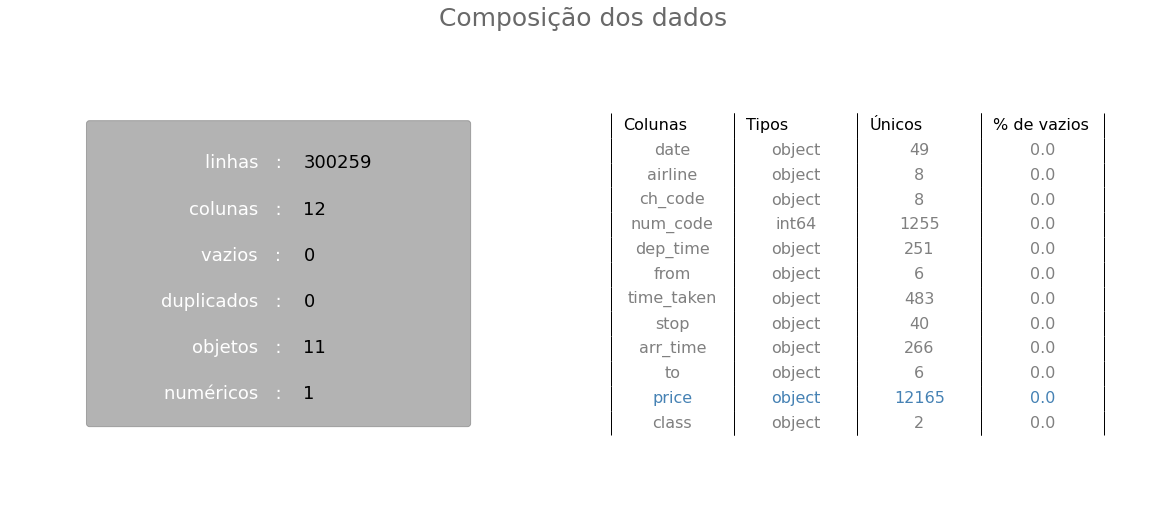

In [182]:
DADOS_FUN(Dataset)

In [184]:
def manipulacao_inicial(dt):
  """
  Função de Tratamento
  --

  Essa função foi criada para Passar todo o tratamento dos dados onde será feito:

  1. Manipulação dos dados de Tempo:
    - Passando Para o formato Categórico.
    - Mudando o horário para o formato float.
    - Transformar de horas para minutos.
  2. Manipulação de texto
    - Removendo as informações irrelevantes que são repetidas.
    - Fazer uma separação binária.
    - Separar os locais e quantidade.
  3. Modificar Formato
    - Modificar formato dos objetos.
    - Ajustar formato do alvo.
  """

  dt = dt.reset_index(drop=True)
# ------------------------- Manipulando data -----------------------------
  dt['date'] = dt['date'].astype('category') # Formato string.

# ------------------------- Manipulando Horas -----------------------------
  ## departure time

  dt['dep_time'] = dt['dep_time'].str.replace(':','.').astype('float') # Formato continuo.

  ## Arrive time

  dt['arr_time'] = dt['arr_time'].str.replace(':','.').astype('float') # Formato continuo.

  ## Time taken

  def coleta_hm(x):
    " Função para transformar Horas em Minutos como intuito de Facilitar a interpretação do algoritmo"
    try:
      p = re.compile(r'(.*)[h](.*)[m]') # Seleciona todos os dados antes da letra H e entre H e M.
      reew = p.finditer(x)
      for i in reew:
        resultado = int(i.group(1))*60 + float(i.group(2))
      return resultado
    except:
      p = re.compile(r'(.*)[\.](.*)[h]') # Para os casos que há algum tipo de alteração no formato padrão.
      reew = p.finditer(x)
      for i in reew:
        resultado = int(i.group(1))*60 + float(i.group(2))
      return resultado


  dt['time_taken'] = dt['time_taken'].apply(lambda x: coleta_hm(x))

# ------------------------- Manipulando Stop -----------------------------

  for i in ['\t','\n','Via','+']:
    dt['stop'] = dt['stop'].str.replace(i,'')
  st1, st2 = [], []
  for i in dt['stop'].str.replace('-',' ').str.replace('stop',' ').str.strip().str.replace('non','0').str.split(' ',2):
    if len(i) > 1:
      st1.append(int(i[0]))
      st2.append(i[-1].strip())
    else:
      st1.append(int(i[0]))
      if int(i[0]) == 0:
        st2.append('sem parada')
      else:
        st2.append('não informado')

  dt['stop_local'] = st2
  dt['stops'] = st1
  dt['stop_org'] = dt['stops'].astype(str) + '_' + dt['stop_local']
  dt = dt.drop(['stop','stop_local','stops'],axis=1)
  dt['stop_org'] = dt['stop_org'].astype('category')

# ------------------------- Manipulando Objetos -----------------------------
  modificar = dt.select_dtypes(include='object').columns.tolist()
  for i in modificar:
    dt[i] = dt[i].astype('category')

# ------------------------- Manipulando Target -----------------------------

  dt['price'] = dt['price'].str.replace(',','').astype(float)


  return dt



In [185]:
# Aplicando dataset na função
dto = manipulacao_inicial(Dataset)

<ipython-input-184-1e6df98ad723>:57: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dt['stop'] = dt['stop'].str.replace(i,'')


In [186]:
# Verificando se as alterações foram feitas
dto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300259 entries, 0 to 300258
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   date        300259 non-null  category
 1   airline     300259 non-null  category
 2   ch_code     300259 non-null  category
 3   num_code    300259 non-null  int64   
 4   dep_time    300259 non-null  float64 
 5   from        300259 non-null  category
 6   time_taken  300259 non-null  float64 
 7   arr_time    300259 non-null  float64 
 8   to          300259 non-null  category
 9   price       300259 non-null  float64 
 10  class       300259 non-null  category
 11  stop_org    300259 non-null  category
dtypes: category(7), float64(4), int64(1)
memory usage: 13.5 MB


In [187]:
# Comparar o código inicial com o atualizado
Dataset.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,16-03-2022,Air India,AI,867,21:30,Mumbai,21h 50m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:20,Hyderabad,"45,693",Business
1,23-02-2022,Indigo,6E,512,12:55,Kolkata,08h 00m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:55,Delhi,"6,489",Economy
2,27-03-2022,Air India,AI,809,10:00,Mumbai,12h 20m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,22:20,Kolkata,"49,725",Business
3,02-03-2022,Indigo,6E,7298,13:55,Hyderabad,09h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:40,Bangalore,"5,136",Economy
4,24-02-2022,Indigo,6E,982,08:50,Hyderabad,05h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,14:15,Delhi,"10,437",Economy


In [188]:
dto.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,arr_time,to,price,class,stop_org
0,16-03-2022,Air India,AI,867,21.30,Mumbai,1310.0,19.20,Hyderabad,45693.0,Business,1_não informado
1,23-02-2022,Indigo,6E,512,12.55,Kolkata,480.0,20.55,Delhi,6489.0,Economy,1_não informado
2,27-03-2022,Air India,AI,809,10.00,Mumbai,740.0,22.20,Kolkata,49725.0,Business,1_não informado
3,02-03-2022,Indigo,6E,7298,13.55,Hyderabad,585.0,23.40,Bangalore,5136.0,Economy,1_não informado
4,24-02-2022,Indigo,6E,982,8.50,Hyderabad,325.0,14.15,Delhi,10437.0,Economy,1_não informado


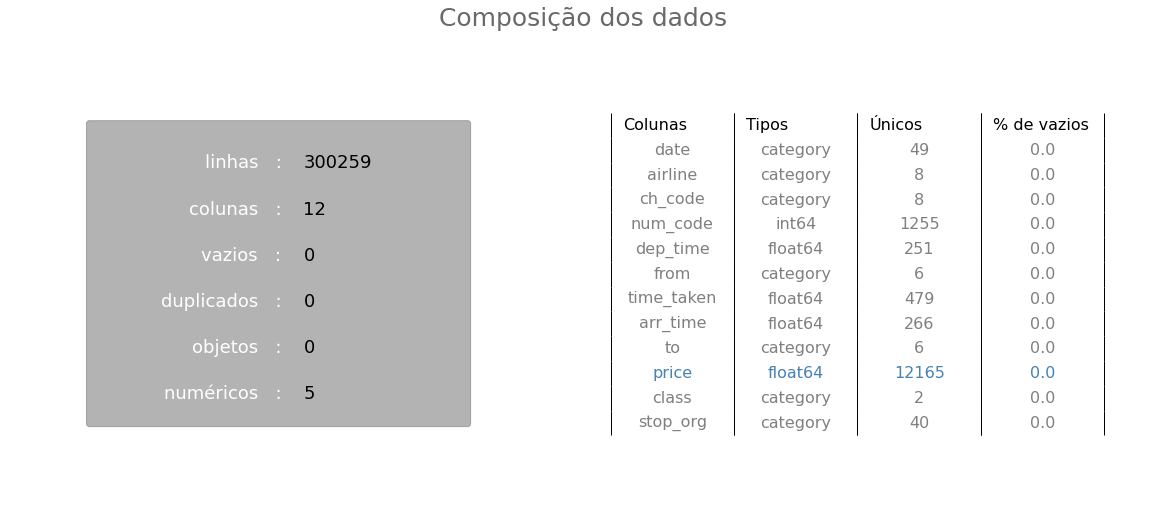

In [189]:
DADOS_FUN(dto)

## Análise Exploratória

A análise exploratória se divide em 3 etapas

1. **Análise dos categóricos**
  - Os dados categóricos serão avaliados com base na sua frequência através da visualização dos gráficos de barra.

2. **Análise Numérica**
  - Os numéricos serão avaliados com base na sua distribuição com o gráfico de caixa, pois é possível visualizar tanto os outliers como as medidas centrais desses dados.

3. **Correlação** 
  - A depender da conclusão das análises anteriores, pode-se ser feito uma decomposição dos dados para um estudo mais preciso, como: Decompor datas, juntar códigos, etc....
  - Será gerado duas correlações, uma com os categóricos e outra com os numéricos, um sendo com um gráfico de caixa e outro com um Scatter.

### Funções

In [259]:
def barras(dt):
  """
  Função irá retornar uma imagem contendo gráficos de barra
  com as categorias de cada feature.

  """
# ------------------------------------- Configuração de imagem ---------------
  figura = plt.figure(figsize=(25, 20))
  tamanho = (3, 3)
  clo = dt.select_dtypes('category').describe().T.sort_values(by='unique',ascending=False).index.tolist()
  dt_e = dt.loc[:,clo]
  box = dict(boxstyle='round',alpha=0.5, color='teal')
  plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    hspace=0.6,
                    wspace=0.3)

  showed_elements = 10
  figura.suptitle('Features Qualitativas: Distribuição dos dados', fontsize=30, color='dimgrey')
# ------------------------------------- Criação das barras -------------------
  ce = 0
  for r in range(3):
    for c in range(3):
    
      try:
        cl = dt_e.columns[ce]
        pos = (r,c)
        ax = plt.subplot2grid(tamanho, pos)
        dados_temporarios = dt_e.iloc[:,ce].value_counts()
        size = dados_temporarios.shape[0]
      
        # ------------ entre showed elements e menor valores ------------
        if (size <= showed_elements) & (size > 2):
              ## Cores
          cores = ['lightseagreen' if g==0 else 'lightgrey' for g in range(size)]


              ## Barras
          fig = sns.barplot(
              y = dados_temporarios.index.tolist(),
              x = dados_temporarios.tolist(),
              orient='h' , ax=ax, palette=cores)
          
        # ------------ menor que 2 ------------
        elif (size <= 2):
              ## Cores
          cores = ['cadetblue']


              ## Barras
          fig = sns.barplot(
              y = dados_temporarios.index.tolist(),
              x = dados_temporarios.tolist(),
              orient='h' , ax=ax, palette=cores)
          
           # Mostrar porcengatem de cada categoria.
          a = ((dados_temporarios.values / dt.shape[0])*100).tolist()
          b = dados_temporarios.values.tolist()
          c = []
          for aa, bb in zip(a, b):
            c.append(f'{bb} '+ f'({aa:.2f}%)')

          # Mostrar dados no gráfico.
          co = 0  

          for val, posi in zip(c, dados_temporarios.values):

            fig.annotate(
                val,
                xy =  (100000, co),
                fontsize=10,
                color='black'
            )
            co +=1

        # ------------ maior que os mostrados ------------
        elif (size > showed_elements):
              ## Cores
          cores = ['lightseagreen' if g==0 else 'lightgrey' for g in range(showed_elements)]

              ## Barras
          fig = sns.barplot(
              y = dados_temporarios.index.tolist()[:showed_elements],
              x = dados_temporarios.tolist()[:showed_elements],
              orient='h' , ax=ax, palette=cores)  

              ## Configuração de texto          
          ax.text(dados_temporarios.max()*(1.30), showed_elements/2, f'Serie contendo\n{dados_temporarios.shape[0]}\nelementos', 
            bbox=box, fontsize=16, horizontalalignment='center',color='white')
          
          ax.set_xlim([0, dados_temporarios.max()*(1.50)])


        ## Ajustes 
        ax.set_title(cl.capitalize(),fontsize=15, horizontalalignment='left', y=1.1, x=0, color='dimgrey')

        for i in ['top','left','right']:
          ax.spines[i].set_visible(False)

        plt.tick_params(axis='y', left=False, labelleft=True)

        ax.set(ylabel='', xlabel='')
        
        ce+=1


      except:
        continue

  return plt.show(), figura.savefig(f'{nome}');

In [435]:
def posicao(a, b):
  """ Funçõa para determinar a posição de cada imagem """

  if b < 2:
    b +=1
    return a, b
  else:
    a += 1
    b = 0
    return a, b
    
def caixas(df, tamanho):
  """
  Função irá retornar uma imagem de gráficos de caixa
  """
	# Configuração Inicial
  
  tamanho = tamanho
  figura = plt.figure(figsize=(25,15))
  plt.suptitle('Dispersão dos dados numéricos', fontsize=30, color='dimgrey')
  a, b = 0, 0

  for ii in df:
								## Pos
    pos = (a,b)
    ax1 = plt.subplot2grid(tamanho, pos)
    a, b = posicao(a,b)
						    ## Plot
    box = sns.boxplot(
        orient='h',
        x = df[ii],
        ax= ax1,
        width = 0.3,
        boxprops= {"facecolor": (.4, .6, .8, .5), "edgecolor": "grey", "linewidth": 0.5}, # Cor do box e cor das bordas do box
        whiskerprops={"color": "grey", "linewidth": 0.5}, # Cor das linhas acima e abaixo do q1 e 13
        capprops={"color": "grey", "linewidth": 0.5}, # Cor da barra limite 
        medianprops={"color": "grey", "linewidth": 0.5}
    )




    box.set_title(f'{ii}',horizontalalignment='left', x=0,fontsize=16,color='grey')

									## Conf
    quantiles = df[ii].quantile([0.25, 0.75]).values.tolist()
    LI = quantiles[0] - ((quantiles[1] - quantiles[0])*1.5)
    LS = quantiles[1] + ((quantiles[1] - quantiles[0])*1.5)
    if LI < df[ii].min():
      LI = df[ii].min()
    if LS > df[ii].max():
      LS = df[ii].max()


    for i in quantiles:
      box.annotate(i, xy=(i+0.1, -0.17), fontsize=15, color='black')

    for i in [int(LI),int(LS)]:
      box.annotate(i, xy=(i+0.1, 0.1), fontsize=15, color='black')
    
    plt.axis('off')

### Análises Quantitativas e Qualitativas

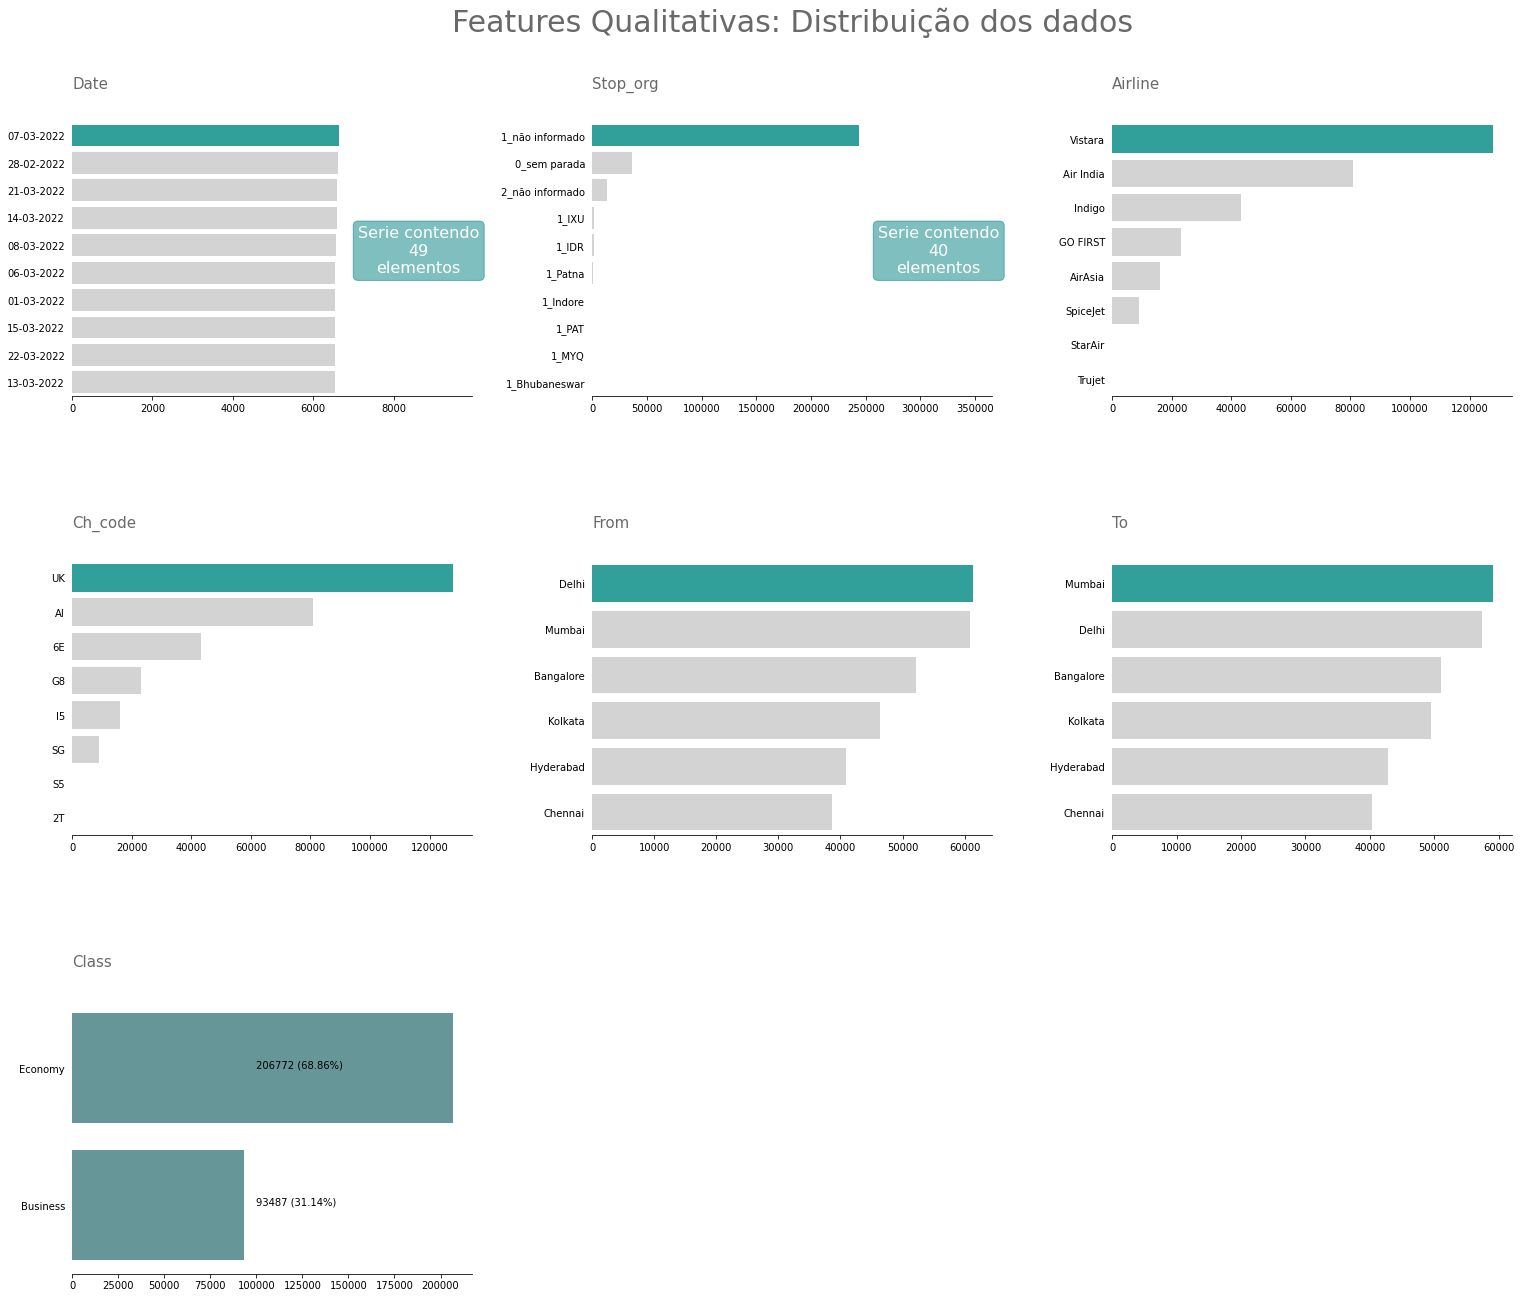

(None, None)

In [260]:
barras(dto, nome='Qualitativos')

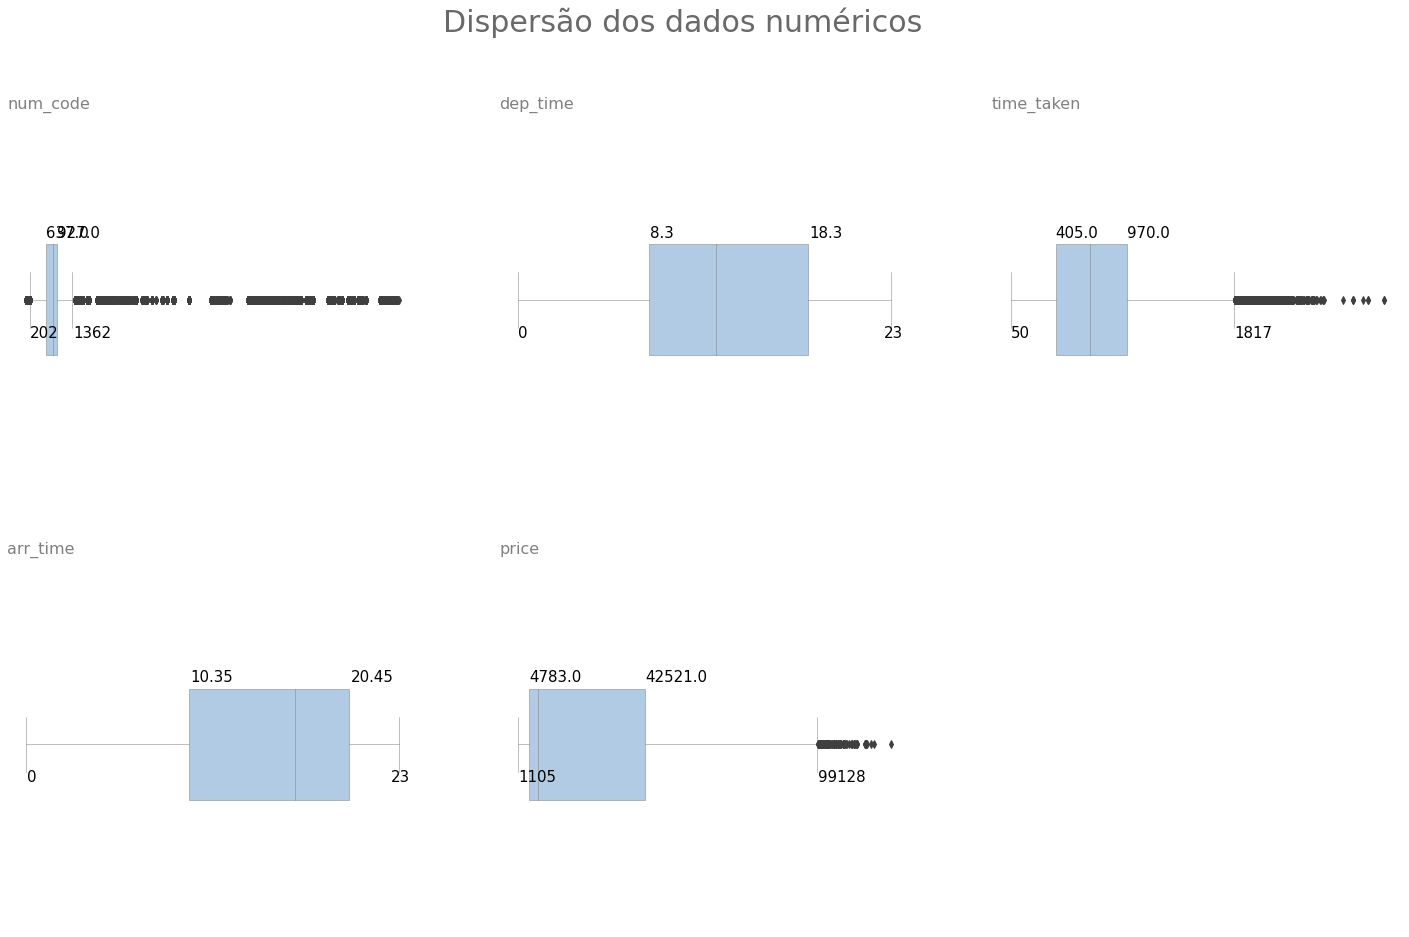

In [261]:
caixas(dto.select_dtypes(include=np.number), (2,3))

### Correlações

### Funções

In [436]:
def feature_generation(df_novo):
  """
  Função criada para a decomposição e criação de novas features do dataset.

  1- Passar a data para o formato datetime
    - Extrair informações de datas, como: Mês, dia da semana, dia.
  2- Extrair período
    - Manhã, tarde, noite e madrugada.
  """

  df = df_novo.copy()

# ==================== Data ======================
  ## Extraindo dia/mês/dia da semana
  df['date'] = pd.to_datetime(df['date'], format="%d-%m-%Y")
  for time, f_time in zip(['dia','mes','dia_da_semana'],['%d','%m','%A']):
    df[time] = df['date'].dt.strftime(f_time).astype('category')

  df['date'] = df['date'].astype(str).astype('category')

# ==================== Código ======================
  df['code'] = df['ch_code'].astype(str) + '-' + df['num_code'].astype(str)

# ==================== Origem-Destino ======================
  df['rota'] = df['from'].astype(str) + '-' +  df['to'].astype(str)

# ==================== Paradas ======================
  df[['stops','stop_local']] = df['stop_org'].str.split('_',2,True)


# ==================== Tempo ======================
  ## Extraindo período 
  def func_per(x):
    if (x >= 0) & (x < 6):
      return 'Madrugada'
    elif (x >= 6) & (x < 12):
      return 'Manhã'
    elif (x >= 12) & (x < 18):
      return 'Tarde'
    elif (x >= 18) & (x <= 23.59): 
      return 'Noite'

  df['periodo_partida'] = df['dep_time'].apply(lambda x: func_per(x))
  df['periodo_chegada'] = df['arr_time'].apply(lambda x: func_per(x))


  new_features = list(set(df) - set(df_novo))
  for i in new_features:
    df[i] = df[i].astype('category')
  return df


In [412]:
def corr_cat(df, df_o):
  """
  Visualização gráfica das features que contem mais de 28 classes.
  Imagem composta por gráficos de caixa.
  """

# ================ Configurações da imagem ====================
  df_c = df.copy()
  tamanho = (8,3) #tamanho da imagem (linhas,colunas)
  figura = plt.figure(figsize=(20, 50)) # Tamanho da imagem
  plt.subplots_adjust(left=0.1, #AJUSTES
                  bottom=0.1,
                  right=0.9,
                  top=0.9,
                  hspace=0.8,
                  wspace=0.4)

  figura.suptitle('Correlações Alvo X Categóricos', fontsize=30, color='dimgrey', y=0.95) # Título
  
# ================ plotagem ====================
  cont_cols = 0
  try:
    for ro in range(4): # Loop para cada linha e coluna da imagem 
      for col in range(3):
                    ## Configurações
        row = ro*2
        feature = df_c.columns.tolist()[cont_cols] # Feature Atual
        pos = (row, col) #Posição do gráfico na imagem
        ax = plt.subplot2grid(tamanho, pos, rowspan=2) # axis
                  ## Ajustar o dataframe
        caixa = sns.boxplot(
            orient='h',
            data = df_o,
            x = 'price',
            y = feature,
            ax=ax,
            palette="Greens")
        cont_cols += 1
        caixa.set_title(f"{feature}", horizontalalignment='left', color='grey', x=0)
        caixa.spines['top'].set_visible(False)
        caixa.spines['right'].set_visible(False)
        caixa.spines['left'].set_visible(False)
        caixa.spines['bottom'].set_color('darkgrey')
        caixa.tick_params(axis='y', colors='black')
        caixa.tick_params(axis='x', colors='darkgrey')
        caixa.set_ylabel('', horizontalalignment='right', y=1.0, color='black')

  except:
    pass

In [414]:
def corr_cate(df, df_o):
  """
  Visualização gráfica das features que contem menos de 28 classes.
  Imagem composta por gráficos de caixa.
  """
# ================ Configurações da imagem ====================
  df_c = df.copy()
  tamanho = (4,3) #tamanho da imagem (linhas,colunas)
  figura = plt.figure(figsize=(20, 50)) # Tamanho da imagem
  plt.subplots_adjust(left=0.1, #AJUSTES
                  bottom=0.1,
                  right=0.9,
                  top=0.9,
                  hspace=0.8,
                  wspace=0.4)

  figura.suptitle('Correlações Alvo X Categóricos', fontsize=30, color='dimgrey', y=0.95) # Título
# ================ plotagem ====================
  cont_cols = 0
  try:
    for row in range(4): # Loop para cada linha e coluna da imagem 
      for col in range(3):
                    ## Configurações

        feature = df_c.columns.tolist()[cont_cols] # Feature Atual
        pos = (row, col) #Posição do gráfico na imagem
        ax = plt.subplot2grid(tamanho, pos,rowspan=2) # axis
                  ## Ajustar o dataframe
        caixa = sns.boxplot(
            orient='h',
            data = df_o,
            x = 'price',
            y = feature,
            ax=ax,
            palette="Greens")
        cont_cols += 1
        caixa.set_title(f"{feature}", horizontalalignment='left', color='grey', x=0)
        caixa.spines['top'].set_visible(False)
        caixa.spines['right'].set_visible(False)
        caixa.spines['left'].set_visible(False)
        caixa.spines['bottom'].set_color('darkgrey')
        caixa.tick_params(axis='y', colors='black')
        caixa.tick_params(axis='x', colors='darkgrey')
        caixa.set_ylabel('', horizontalalignment='right', y=1.0, color='black')

  except:
    pass

In [422]:
def corr_num(df):
  """
  Visualização gráfica das features que são numéricas.
  Imagem composta por gráficos de dispersão.
  """
# ================ Configurações da imagem ====================
  df_c = df.copy()
  df_c = df_c.select_dtypes(include=np.number) # Seleciona um df só com categóricos
  tamanho = (6,3) #tamanho da imagem (linhas,colunas)
  figura = plt.figure(figsize=(20, 50)) # Tamanho da imagem
  plt.subplots_adjust(left=0.1, #AJUSTES
                  bottom=0.1,
                  right=0.9,
                  top=0.9,
                  hspace=0.5,
                  wspace=0.3)

  figura.suptitle('Correlações Alvo X Categóricos', fontsize=30, color='dimgrey', y=0.95) # Título

  # ================ plotagem ====================
  cont_cols = 0
  try:
    for row in range(3): # Loop para cada linha e coluna da imagem 
      for col in range(3):
                    ## Configurações
          
        feature = df_c.columns.tolist()[cont_cols] # Feature Atual
        pos = (row, col) #Posição do gráfico na imagem
        ax = plt.subplot2grid(tamanho, pos) # axis
                  ## Ajustar o dataframe
        plot = sns.scatterplot(
            data = df,
            x = 'price',
            y = feature,
            hue='class',
            ax=ax,
            marker='+', color='grey'
        )

        cont_cols += 1

        plot.set_title(f"{feature}", horizontalalignment='left', color='grey', x=0)
        plot.spines['top'].set_visible(False)
        plot.spines['right'].set_visible(False)
        plot.spines['left'].set_visible(False)
        plot.spines['bottom'].set_color('darkgrey')
        plot.tick_params(axis='y', colors='black')
        plot.tick_params(axis='x', colors='darkgrey')
        plot.set_ylabel('', horizontalalignment='right', y=1.0, color='black')
  except:
      pass


### Análise

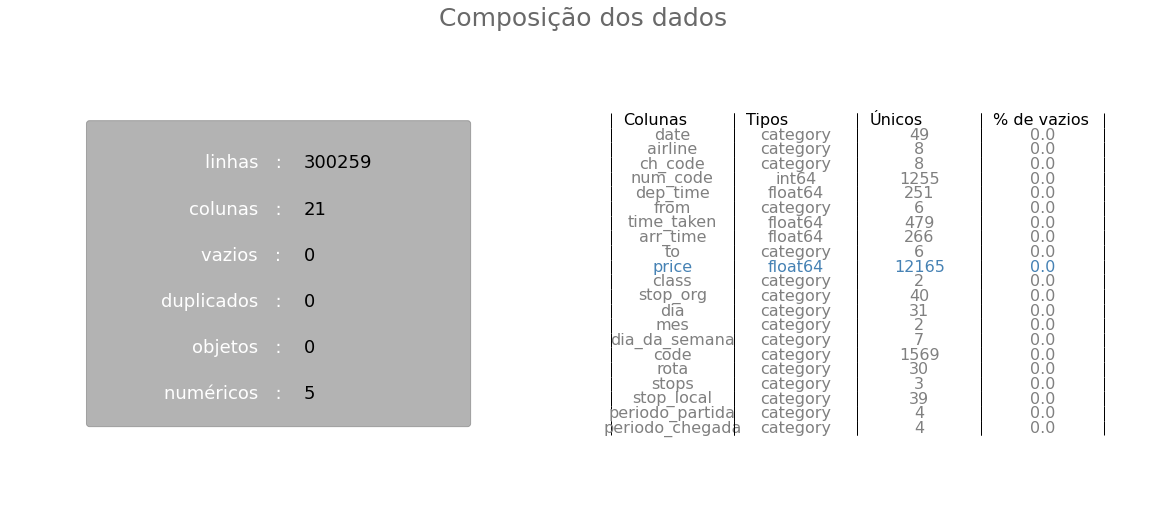

In [424]:
dt_dec = feature_generation(dto)
DADOS_FUN(dt_dec)

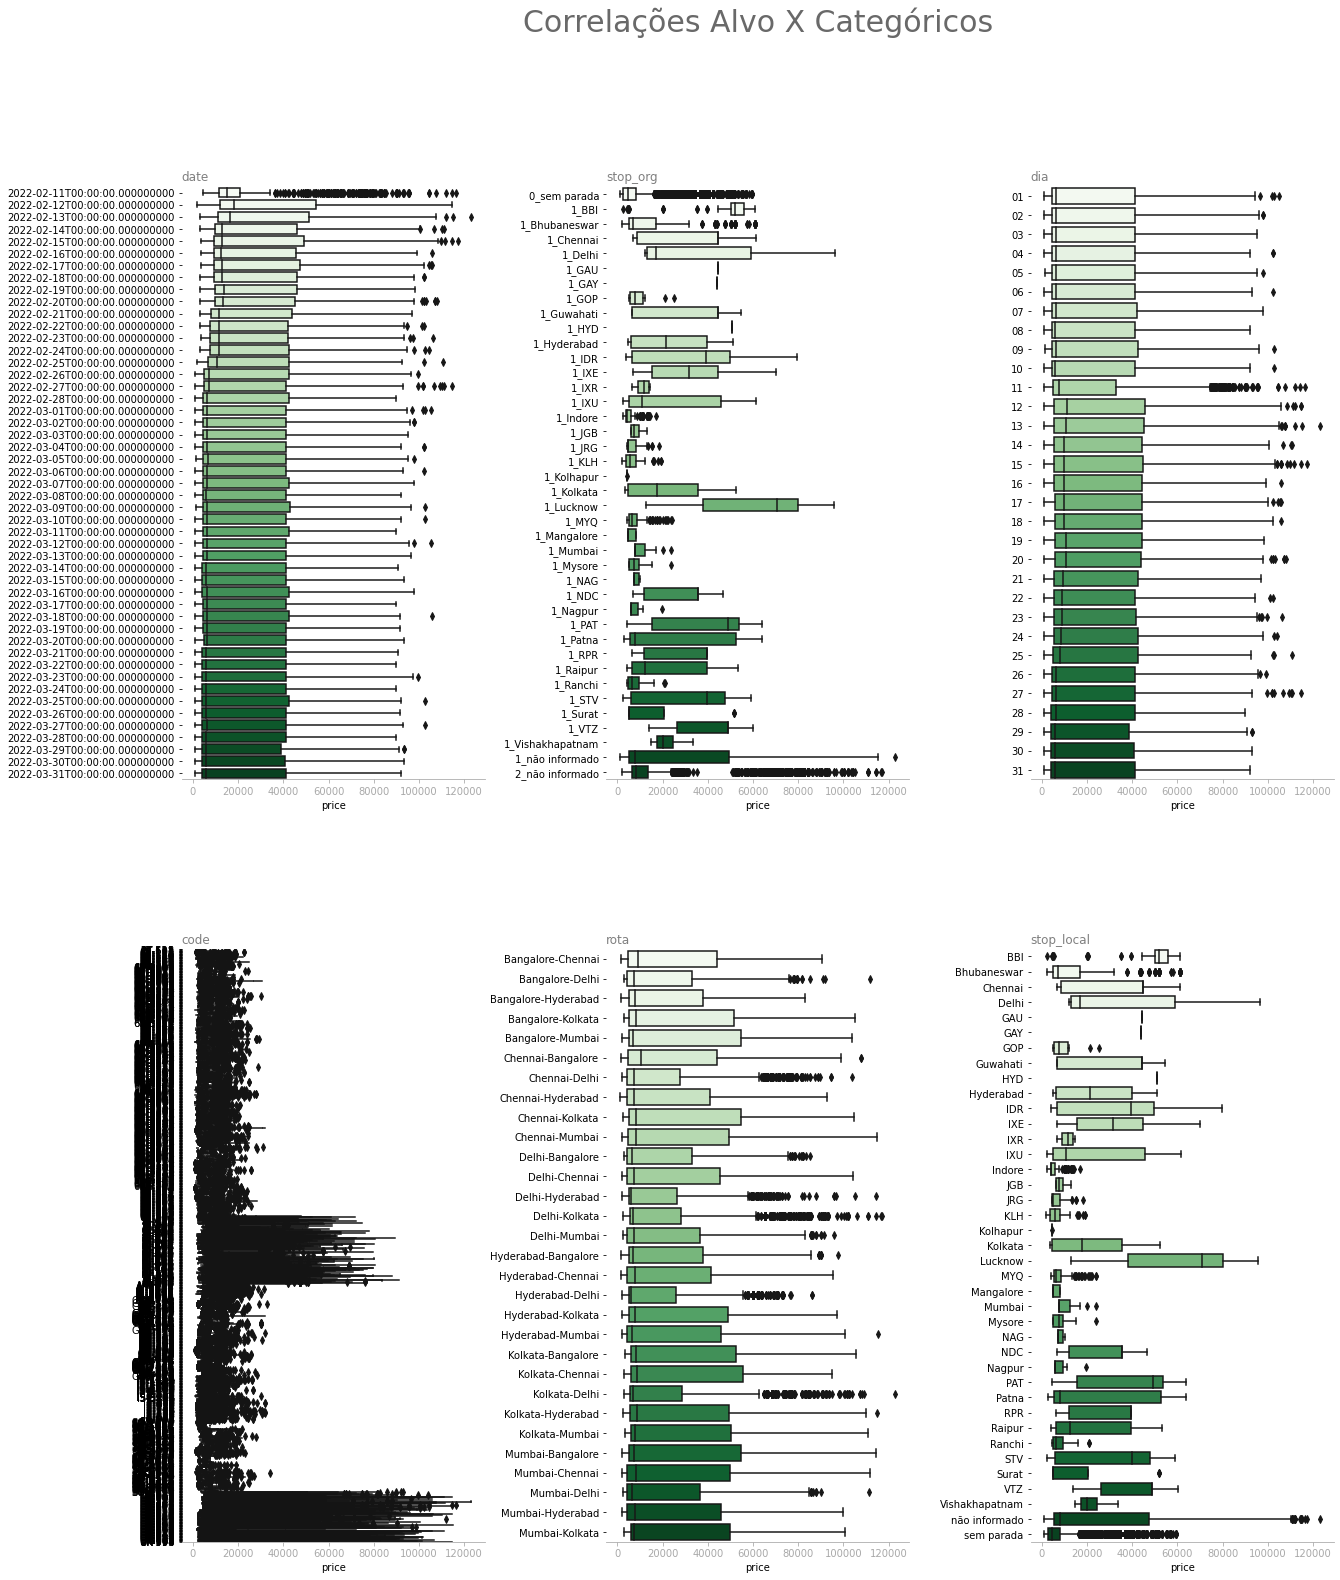

In [413]:
corr_cat(dt_dec[dt_dec.nunique()[dt_dec.nunique() > 28].index].select_dtypes(include='category'), dt_dec)

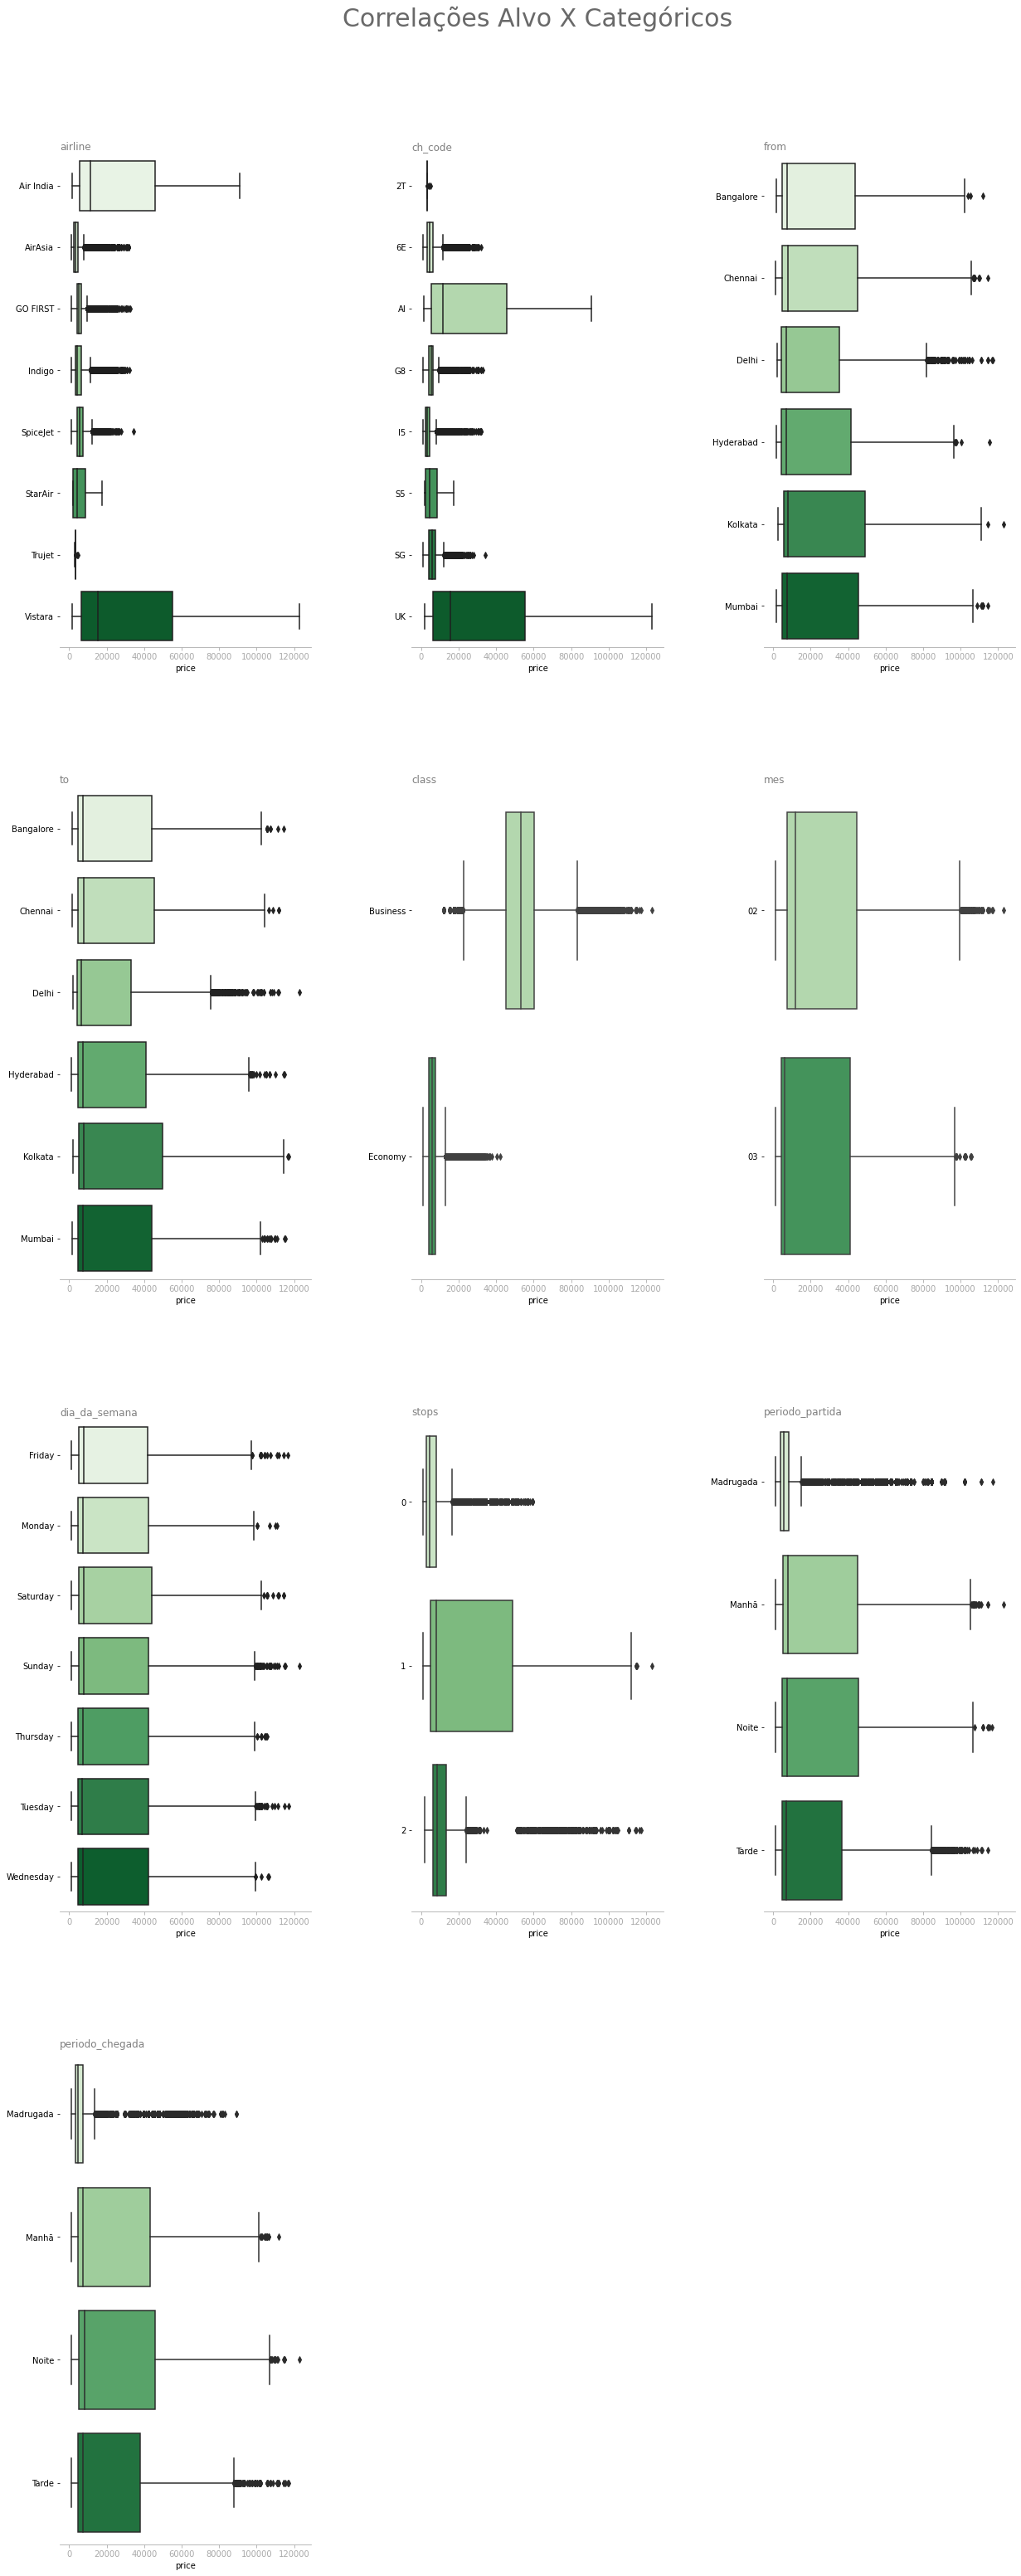

In [416]:
corr_cat(dt_dec[dt_dec.nunique()[dt_dec.nunique() <= 28].index], dt_dec)

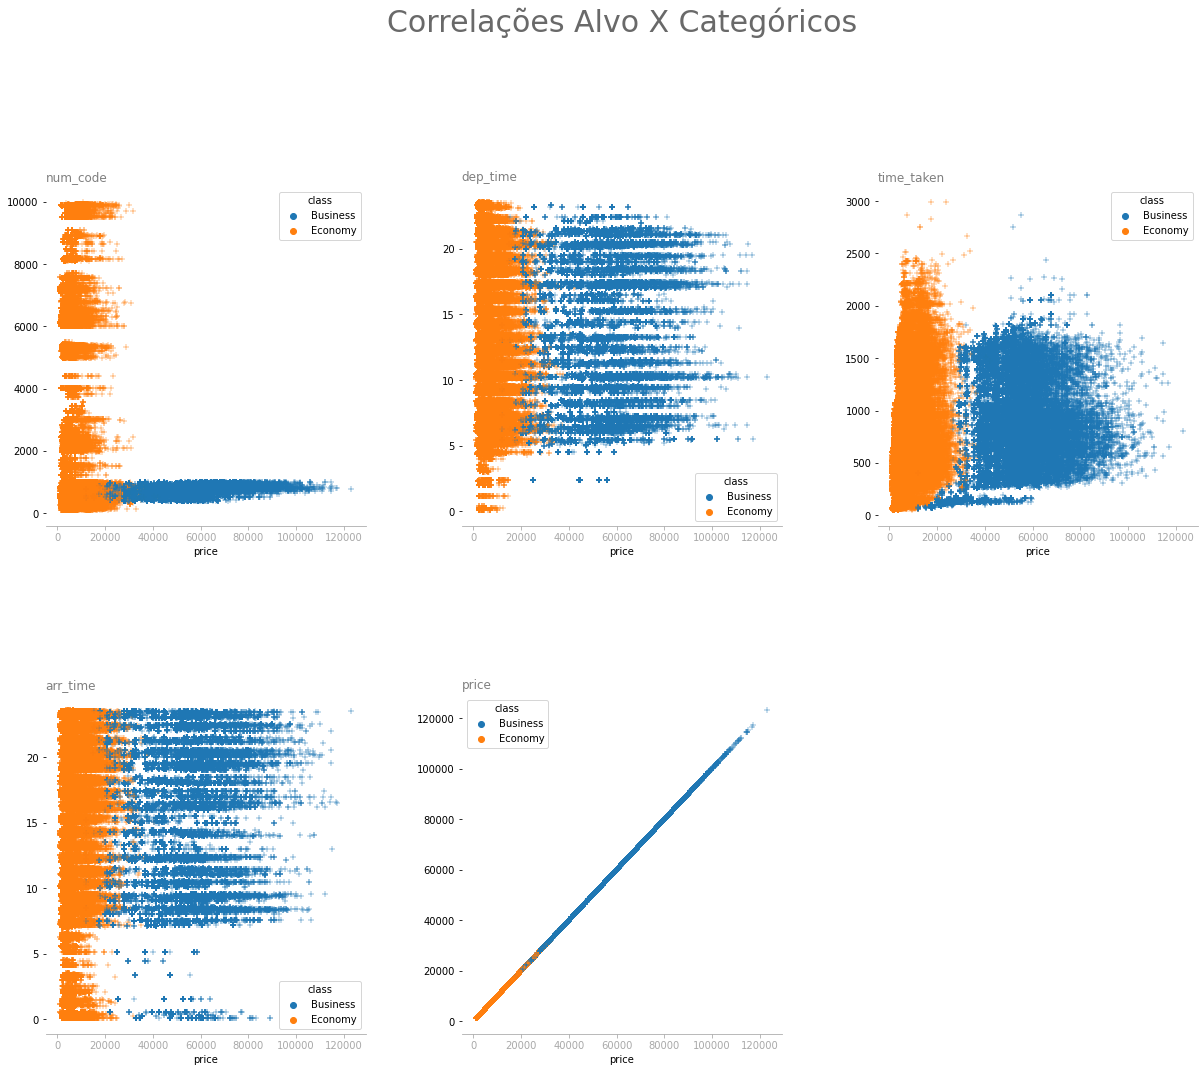

In [423]:
corr_num(dt_dec)

<font color='grey'><h2> Conclusão da análise </h2></font>

- **Qualitativos**:
  - Dados com mais de 28 categorias: 
    - Data: Se mostra bem padrão, tendo somente uma data com uma faixa de preço menor.
    - Dia: A mesma situação se repete.
    - code: Aparenta ter uma grande relação com a variação do preço das passagens.
    - O local de paradas na escala e a relação entre quantidade de escalas x locais da escala aparentam ser bem semelhantes, mas com uma leve diferença em algumas classificações, além de também variar consideravelmente.
    - A rota demonstra que certos caminhos o preço elevado da passagem chega como um outliers, além de apresentar diversidade na distribuição dos preços.

  - Dados com menos de 28 categorias:
    - airline e ch_Code aparentam serem dados redundantes, subentendo que cada empresa aérea tem seu código na passagem.
    - Partida e Chegada apresentam certas cidades com uma distribuição dos preços abaixo de outras cidades.
    - A classe da passagem é o maior influenciador nos preços da passagem.
    - O mês apresenta uma leve diferença.
    - O dia da semana era um dado que, eu particularmente, esperava ter uma influência maior nos preços das passagens, mas se demonstrou bem constante a distribuição desses dados ao decorrer da semana.
    - Curiosamente os voos sem paradas (0) acabaram sendo mais baratos do que os com escala.
    - Período de chegada e de partida acabam sendo dados redundantes, mas demonstram que o horário de ambos tem uma influência sobre o preço.

- **Quantitativos**:
  - Número do código apresentou uma grande influência no valor da passagem, sendo os mais caros abaixo de 2000.
  - Hora de partida como a hora de chegada apresentam diferenças nas suas concentrações de dados, e refletem certas características observadas anteriormente sobre o preço e o horário do voo.
  - Com o auxílio da separação de dados pela classe do voo, é possível observar bem a diferença no tempo de voo que a diferença do preço é puramente sobre a classe e não sobre o tempo de voo.

- **Deletar Dados**
  - Sendo assim, alguns dados podem ser excluídos, sendo eles:periodo_chegada, dia_da_semana, to e ch_code

# Exportação dos dados

In [429]:
dt_final = dt_dec.drop(['periodo_chegada','dia_da_semana','to','ch_code'], axis=1)

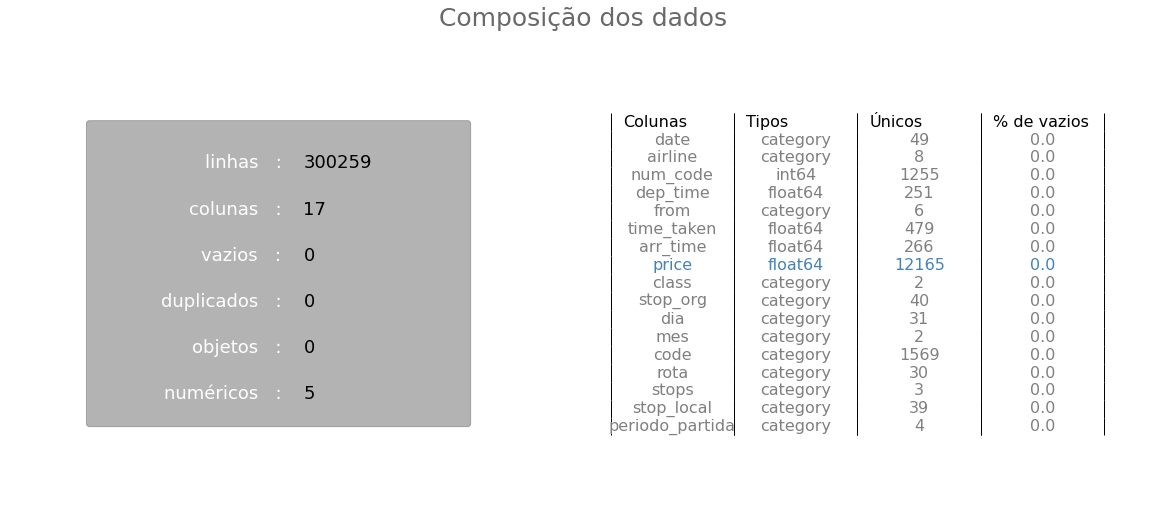

In [432]:
DADOS_FUN(dt_final)

In [434]:
dt_final.to_csv('/content/drive/MyDrive/Colab Assuntos Exemplos/Regressão/Preço Passagens/dados_tratados.csv')